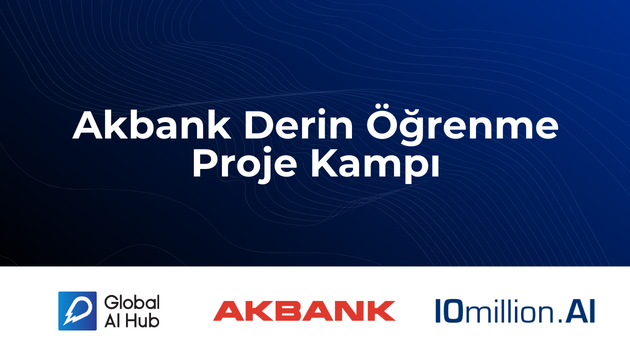


# 1. Importing Necessary Libraries

**Purpose:**

This cell imports all the essential libraries and modules required for data processing, model building, training, and evaluation.

**Key Libraries:**

os: Handles file and directory operations.

numpy, pandas: For data manipulation and analysis.

matplotlib, seaborn: Used for data visualization and plotting.

tensorflow.keras: Contains functions for building, training, and evaluating neural networks.

sklearn: Provides various utilities for data splitting, scaling, and evaluating model performance.

warnings: Suppresses unwanted warnings during execution.


In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings

warnings.filterwarnings("ignore")

# 2. Plotting Confusion Matrix Function

**Purpose:** 

Visualizes the confusion matrix, which helps in understanding how well the model is performing by showing the relationship between true and predicted labels for each class.

**Key Functions:**

confusion_matrix: Calculates the confusion matrix.

sns.heatmap: Creates a heatmap for visualizing the matrix.


In [31]:
def plot_confusion_matrix(y_true, y_pred, class_labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels,
                yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 3. Creating Image Data Generators

**Purpose:**

Prepares image data generators for training and validation data with data augmentation (rotation, flipping) to improve generalization.


**Key Parameters:**

rescale: Scales pixel values to [0, 1].

rotation_range, horizontal_flip, vertical_flip: Augment the training data by rotating and flipping the images.


In [106]:
def create_data_generators(img_height=128, img_width=128):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.2
    )
    
    valid_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2
    )
    return train_datagen, valid_datagen

# 4. Loading and Preprocessing Data

**Purpose:**

Loads images from the dataset directory, preprocesses them (rescaling, reshaping), and organizes the data into features (X) and labels (y).


**Key Steps:**

ImageDataGenerator: Used to load and preprocess images.

flow_from_directory: Fetches images from the specified directory.

X_flat: Flattened image array to be fed into a neural network.


In [107]:
def load_and_preprocess_data(fish_dir, img_height=128, img_width=128):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
        fish_dir,
        target_size=(img_height, img_width),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )
    
    images, labels = [], []
    for i in range(len(generator)):
        batch = next(generator)
        images.append(batch[0])
        labels.append(batch[1])
        if (i + 1) * 32 >= generator.samples:
            break
            
    X = np.concatenate(images)
    y = np.concatenate(labels)
    X_flat = X.reshape(X.shape[0], -1)
    
    inverse_class_indices = {v: k for k, v in class_indices.items()}
    sampled_images = {}
    
    for i in range(len(generator)):
        batch_images, batch_labels = next(generator)
        for img, label in zip(batch_images, batch_labels):
            class_idx = np.argmax(label)
            class_name = inverse_class_indices[class_idx]
            
            if class_name not in sampled_images:
                sampled_images[class_name] = img
                if len(sampled_images) == len(class_indices):
                    break
        if len(sampled_images) == len(class_indices):
            break
    
    plt.figure(figsize=(36, 22))
    for idx, (class_name, img) in enumerate(sampled_images.items(), 1):
        plt.subplot(1, len(class_indices), idx)
        plt.imshow(img)
        plt.title(f"Class: {class_name}")
        plt.axis('off')
    plt.show()
    
    return X_flat, y, generator.class_indices

#  5. Creating the Neural Network Model

**Purpose:**

Defines a Sequential neural network model architecture with dense layers, batch normalization, and dropout to reduce overfitting.

**Key Layers:**

Dense: Fully connected layers with ReLU activation.
BatchNormalization: Normalizes outputs to improve model stability.
Dropout: Randomly drops neurons during training to prevent overfitting.

In [34]:
def create_ann_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# 6. Training the Model

**Purpose:**

Trains the neural network model on the training data, using validation data to tune hyperparameters and avoid overfitting.

**Key Components:**

ModelCheckpoint: Saves the best model during training.

EarlyStopping: Stops training early if no improvement is observed.

ReduceLROnPlateau: Reduces learning rate if validation performance plateaus.

In [54]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    checkpoint = ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=25,
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=7,
        min_lr=1e-6
    )
    
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[checkpoint, early_stopping, reduce_lr],
        verbose=1
    )
    
    return history

# 7. Plotting Training History

**Purpose:**

Visualizes the training and validation accuracy/loss over time to monitor model performance during training.

**Key Functions:**

plt.plot: Plots the training and validation metrics (accuracy/loss).


In [37]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


In [55]:
   # Parametreler
IMG_HEIGHT, IMG_WIDTH = 128,128
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'
    

# 8. Data Splitting

**Purpose:** 

Splits the dataset into training and validation sets (80% training, 20% validation).

**Key Function:**

train_test_split: Splits data into random training and validation sets.

Found 18000 images belonging to 9 classes.


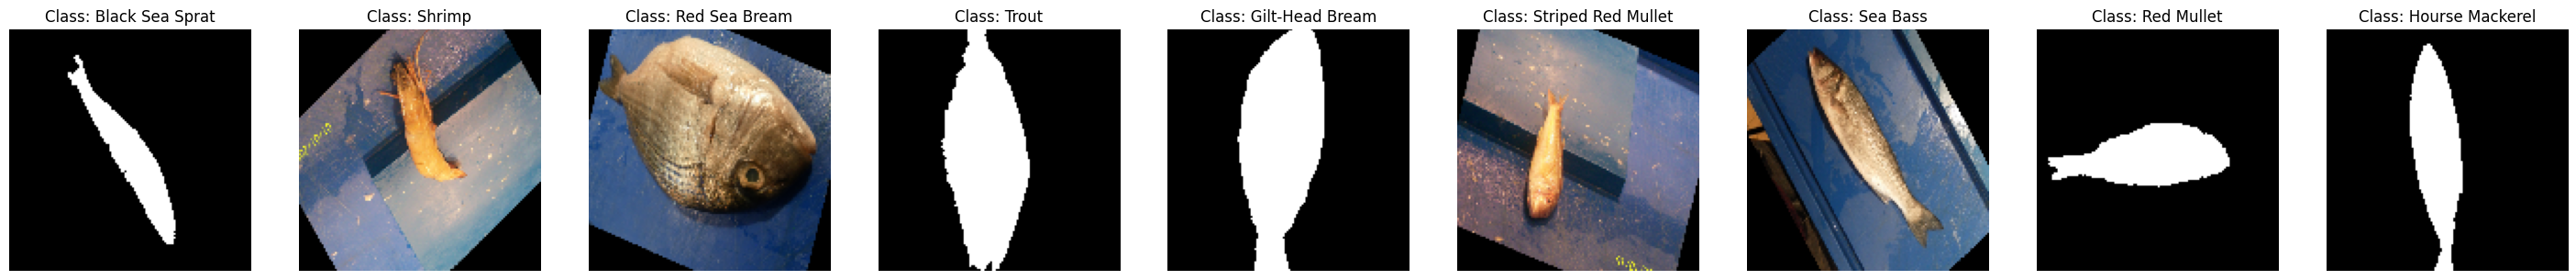

In [108]:
    
    # Veri yükleme ve ön işleme
X, y, class_indices = load_and_preprocess_data(fish_dir, IMG_HEIGHT, IMG_WIDTH)


In [60]:
    # Veri bölme
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 9. Standardizing Data

**Purpose:**

Standardizes the features by removing the mean and scaling to unit variance to improve model training.

**Key Function:**

StandardScaler: Used to standardize the dataset's features.

In [61]:
    
    # Veri standardizasyonu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [62]:
    # Model oluşturma
input_shape = X_train_scaled.shape[1]
num_classes = y_train.shape[1]
model = create_ann_model(input_shape, num_classes)


# 10. Model Summary

**Purpose:**

Prints a summary of the model, including the number of layers, parameters, and shapes.

In [63]:
    
    # Model özeti
model.summary()
    


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 1024)           │    50,332,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,030,537 (194.67 MB)

 Trainable params: 51,026,697 (194.65 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [64]:
    # Model eğitimi
history = train_model(model, X_train_scaled, y_train, X_val_scaled, y_val)


Epoch 1/100
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2273 - loss: 2.3097
Epoch 1: val_accuracy improved from -inf to 0.47028, saving model to best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - accuracy: 0.2275 - loss: 2.3083 - val_accuracy: 0.4703 - val_loss: 1.3833 - learning_rate: 0.0010
Epoch 2/100
446/450 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3908 - loss: 1.5852
Epoch 2: val_accuracy improved from 0.47028 to 0.60472, saving model to best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.3911 - loss: 1.5844 - val_accuracy: 0.6047 - val_loss: 1.0762 - learning_rate: 0.0010
Epoch 3/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5114 - loss: 1.3011
Epoch 3: val_accuracy improved from 0.60472 to 0.67222, saving model to best_model.keras
450/450 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.5115 - loss: 1.3010 - val_accuracy: 0.6722 - val_loss: 0.9195 - learning_rate: 0.0010
Epoch 4/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/

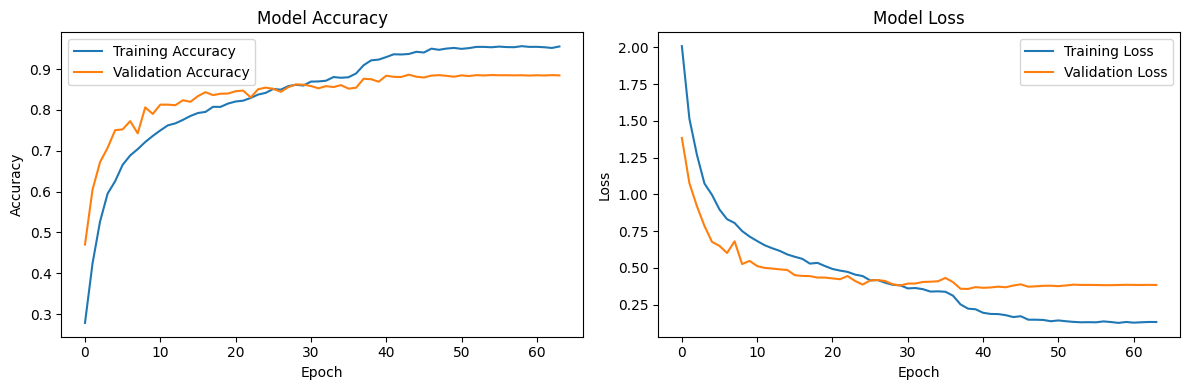

In [65]:
    
    # Sonuçları görselleştirme
plot_training_history(history)


# 11. Model Evaluation

**Purpose:**

Evaluates the trained model on the validation set and prints the final accuracy.

**Key Function:**

evaluate: Evaluates the model's performance on the given data.

In [66]:
    
    # Model değerlendirme
test_loss, test_accuracy = model.evaluate(X_val_scaled, y_val)
print(f"\nTest accuracy: {test_accuracy:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8664 - loss: 0.3797

Test accuracy: 0.8750


# 12. Making Predictions

**Purpose:**

Generates predictions for the validation data and converts them into class labels.

**Key Function:**

predict: Predicts class probabilities for each sample.

In [67]:
    # Tahminler ve değerlendirme
predictions = model.predict(X_val_scaled)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_val, axis=1)


113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


# 13. Plotting Confusion Matrix

**Purpose:** 
Plots a confusion matrix to visualize the classification results, helping to analyze where the model is misclassifying.

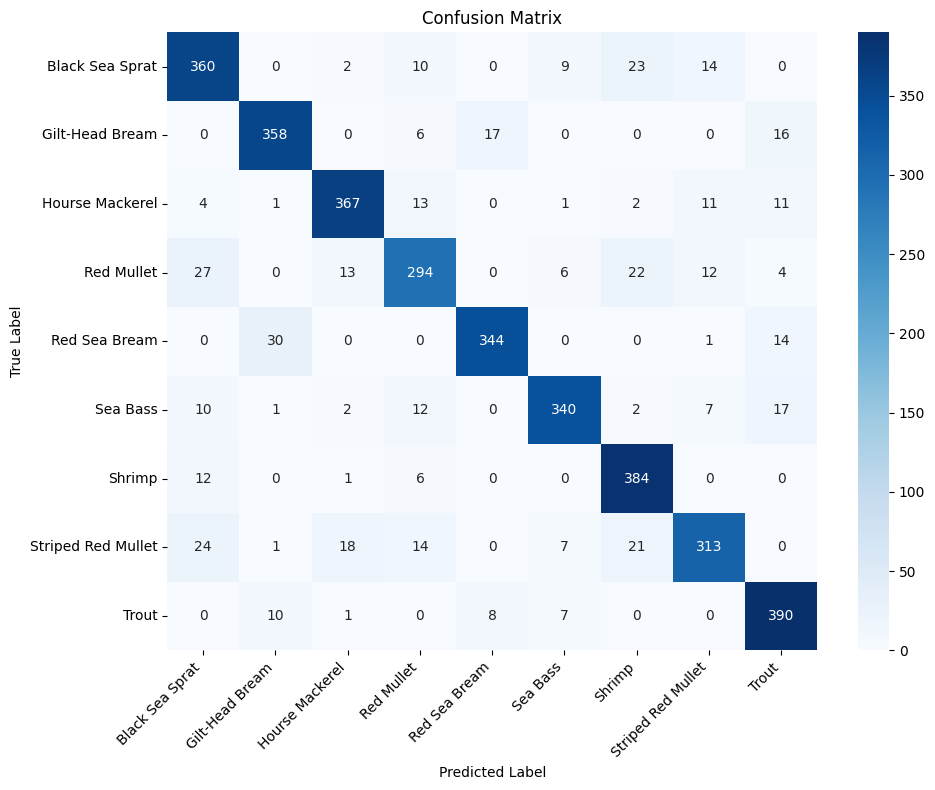

In [68]:
    
    # Confusion matrix
class_labels = list(class_indices.keys())
plot_confusion_matrix(y_true, y_pred, class_labels)

# 14. Classification Report

**Purpose:**

Displays precision, recall, F1-score, and support for each class in the dataset, providing a detailed evaluation of the model’s performance.

**Key Function:**

classification_report: Generates a text report showing the performance metrics for each class.

In [69]:
    
    # Sınıflandırma raporu
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:
                    precision    recall  f1-score   support

   Black Sea Sprat       0.82      0.86      0.84       418
   Gilt-Head Bream       0.89      0.90      0.90       397
   Hourse Mackerel       0.91      0.90      0.90       410
        Red Mullet       0.83      0.78      0.80       378
     Red Sea Bream       0.93      0.88      0.91       389
          Sea Bass       0.92      0.87      0.89       391
            Shrimp       0.85      0.95      0.90       403
Striped Red Mullet       0.87      0.79      0.83       398
             Trout       0.86      0.94      0.90       416

          accuracy                           0.88      3600
         macro avg       0.88      0.87      0.87      3600
      weighted avg       0.88      0.88      0.87      3600

